# Introduction

The goal of this notebook is to build a surface phase diagram of Mg(0001) with Ca segregation using a machine learning interatomic potential (MLIP).

Reference for the MLIP:
Marvin Poul, Liam Huber, and Jörg Neugebauer. Automated Generation of Structure Datasets for Machine Learning Potentials and Alloys, 12 August 2024, PREPRINT (Version 1) available at Research Square [https://www.researchsquare.com/article/rs-4732459/v1]

Reference for the surface segregation of Mg-Ca alloy:
Jing Yang, K. B. Sravan Kumar, Mira Todorova, and Jörg Neugebauer. Construction and analysis of surface phase diagrams to describe segregation and dissolution behavior of Al and Ca in Mg alloys, Phys. Rev. Materials 7, 095802, 2023

We will use an asymmetric cell, the surface energy follows:

$E^{\rm surf}_{\rm perfect} = [E^{\rm DFT}_{\rm perfect} - n_{\rm Mg}(E_{\rm Mg - bulk}+\mu_{\rm Mg})]/2$

$E^{\rm surf}_{\sigma}(\{\mu_{i}\})  = [E_{\sigma}^{\rm DFT} - \sum_{i = \rm Mg, Ca}n_{i,\sigma}  (E_{i-\rm bulk}^{\rm DFT} + \mu_{i})] - E^{\rm surf}_{\rm perfect} $

We consider the condition of $\mu_{\rm Mg} = 0$, i.e. bulk of Mg metal. 

In [1]:
from pyiron_atomistics import Project

import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [2]:
pr = Project("SURFACE")

# Configure Custom Potential

In [3]:
potential = pd.DataFrame({
    'Name': {0: 'AlCaMg'},
     'Filename': {0: [os.path.abspath('potential_files/Trained.mtp_'),]},
     'Model': {0: 'MTP'},
     'Species': {0: ['Al', 'Ca', 'Mg']},
     'Config': {0: ['pair_style mlip load_from=Trained.mtp_\n', 'pair_coeff * *\n']}
})

# Creating Surfaces

In [4]:
surf = pr.create.structure.surface("Mg", "hcp0001", size=(2,2,10), vacuum=10)

In [5]:
surf.plot3d()

NGLWidget()

# Relax the Surface

In [6]:
job = pr.create.job.Lammps("hcp0001_relax")
job.potential = potential
job.structure = surf
job.calc_minimize(n_print=1)
job.run()

The job hcp0001_relax was saved and received the ID: 1


# adding Ca substitutions to Mg surface

In the function `create_slab`, `surface_indices` specifies the element type of each atom on the surface. For example: for 2x2 surface, it should be a four-element list (0, 0, 0, 0), (0, 0, 0, 1)... 

The elements are specified in `species_symbols`, here 0 represents Mg and 1 represents Ca.

    

In [7]:
def create_slab(surface_indices, size=(2,2,10), vacuum=10): 
    
    Mg_slab = pr.create.structure.surface('Mg', 'hcp0001', size=size, vacuum=vacuum, center=True)
    
    surface_indices = np.array(surface_indices).astype(int)
    species_symbols = np.array(['Mg', 'Ca'])
    layer_z_pos = np.unique(Mg_slab.positions[:,2])
    inds_first_layer = np.argwhere(Mg_slab.positions[:, 2] < layer_z_pos[1]).flatten() # select surface layer
    for layer_index, cell_index in zip(inds_first_layer, surface_indices.flatten()):
        Mg_slab[layer_index] = species_symbols[cell_index]
    
    Mg_slab.center_coordinates_in_unit_cell()    
    return Mg_slab

In [8]:
def relax_surface(struct, job_name):
    job = pr.create.job.Lammps(job_name)
    job.structure = struct
    job.potential = potential
    job.calc_minimize(n_print=1)
    job.run()

Let's test the `create_slab` function

In [9]:
Mg_slab = create_slab((0, 1, 0, 1), size=(2,2,10), vacuum=10)

In [10]:
Mg_slab.plot3d()

NGLWidget()

## 2x2 surface

Now we calculate a few structures on the 2x2 surface, as defined in `p_perms`

In [11]:
repeat = 2
p_perms = [(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 1, 1), (0, 1, 1, 1), (1, 1, 1, 1)]

for p in p_perms:
    Mg_slab = create_slab(p, size=(repeat, repeat, 6))
    p_str = ''.join([str(pp) for pp in p])
    job_name = f'Mg_s{repeat}_Ca{p_str}'     
    relax_surface(Mg_slab ,job_name)

The job Mg_s2_Ca0000 was saved and received the ID: 2
The job Mg_s2_Ca0001 was saved and received the ID: 3
The job Mg_s2_Ca0011 was saved and received the ID: 4
The job Mg_s2_Ca0111 was saved and received the ID: 5
The job Mg_s2_Ca1111 was saved and received the ID: 6


We can look at the energy vs coverage plot

  0%|          | 0/6 [00:00<?, ?it/s]

Text(0, 0.5, 'energy (eV)')

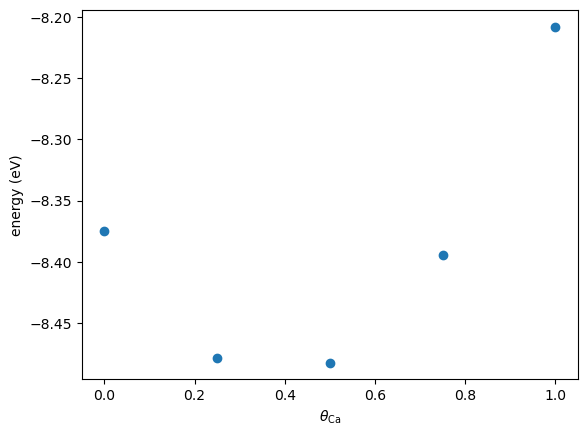

In [12]:
x_lst, e_lst = [], []

for job in pr.iter_jobs(convert_to_object=False):
    # only look at the 2x2 jobs
    if 's2' not in job.job_name:
        continue
        
    n_area = 4

    lat = job.content['input/structure/indices'][:n_area]    
    x = np.mean(lat)
    erg = job.content['output/generic/energy_tot'][-1]/n_area  

    x_lst.append(x)
    e_lst.append(erg)

plt.scatter(x_lst, e_lst)
plt.xlabel(r'$\theta_{\mathrm{Ca}}$')
plt.ylabel('energy (eV)')

## 3x3 surface

Now we calculate a few structures on the 3x3 surface, as defined in `p_perms`

In [13]:
p_perms = [ (0, 0, 0, 0, 0, 0, 0, 0, 0),
            (0, 0, 0, 0, 0, 1, 0, 0, 0),
            (0, 1, 0, 0, 0, 0, 0, 1, 0),
            (1, 0, 0, 0, 1, 0, 0, 0, 0),
            (1, 0, 0, 1, 0, 0, 0, 0, 1),
            (0, 0, 1, 0, 0, 0, 1, 0, 1),
            (0, 1, 0, 0, 1, 0, 0, 1, 0),
            (1, 0, 0, 0, 1, 0, 0, 0, 1),
            (0, 1, 0, 0, 1, 1, 0, 0, 1),
            (1, 1, 0, 1, 0, 0, 0, 1, 0),
            (0, 1, 1, 1, 0, 0, 0, 0, 1),
            (0, 1, 0, 0, 1, 1, 1, 0, 0)]

In [14]:
repeat = 3
for p in p_perms:
    Mg_slab = create_slab(p, size=(repeat, repeat, 6))
    p_str = ''.join([str(pp) for pp in p])
    job_name = f'Mg_s{repeat}_Ca{p_str}'
    relax_surface(Mg_slab ,job_name)

The job Mg_s3_Ca000000000 was saved and received the ID: 7
The job Mg_s3_Ca000001000 was saved and received the ID: 8
The job Mg_s3_Ca010000010 was saved and received the ID: 9
The job Mg_s3_Ca100010000 was saved and received the ID: 10
The job Mg_s3_Ca100100001 was saved and received the ID: 11
The job Mg_s3_Ca001000101 was saved and received the ID: 12
The job Mg_s3_Ca010010010 was saved and received the ID: 13
The job Mg_s3_Ca100010001 was saved and received the ID: 14
The job Mg_s3_Ca010011001 was saved and received the ID: 15
The job Mg_s3_Ca110100010 was saved and received the ID: 16
The job Mg_s3_Ca011100001 was saved and received the ID: 17
The job Mg_s3_Ca010011100 was saved and received the ID: 18


Look at the energies from both 2x2 and 3x3 calculations

  0%|          | 0/18 [00:00<?, ?it/s]

Text(0, 0.5, 'energy (eV)')

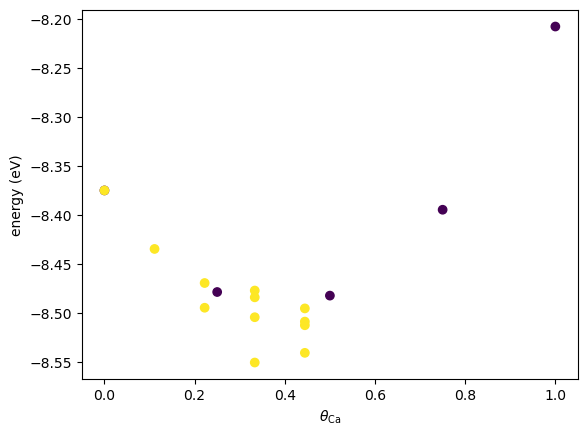

In [15]:
x_lst, e_lst, area_lst = [], [], []


for job in pr.iter_jobs(convert_to_object=False):
        
    if 's2' in job.job_name:
        n_area = 4
    elif 's3' in job.job_name:
        n_area = 9 
    else:
        continue

    lat = job.content['input/structure/indices'][:n_area]    
    x = np.mean(lat)
    erg = job.content['output/generic/energy_tot'][-1]/n_area        
    
    x_lst.append(x)
    e_lst.append(erg)
    area_lst.append(n_area)
    

e_lst = np.array(e_lst)
x_lst = np.array(x_lst)

plt.scatter(x_lst, e_lst, c=area_lst);
plt.xlabel(r'$\theta_{\mathrm{Ca}}$')
plt.ylabel('energy (eV)')

# construct a  pyiron table

pyiron table provides an easy way to put all calculated data into a pandas table

In [16]:
table = pr.create.table(job_name = 'pyiron_table')

In [17]:
# Filtering based on the job
def job_filter_function(job):
    # returns a boolean value if "s" is in it's job name
    return ("s" in job.job_name)

In [18]:
def get_surface_area(job):
    a1 = job.content['input/structure/cell/cell'][0]
    a2 = job.content['input/structure/cell/cell'][1]
    return np.linalg.norm(np.cross(a1, a2))

In [19]:
def get_n_area(job):
    if 's2' in job.job_name:
        n_area = 4
    elif 's3' in job.job_name:
        n_area = 9 
    else:
        n_area = None
    return n_area

In [20]:
table.add.get_energy_tot 
table.add.get_job_id
table.add.get_job_name
table.add.get_volume
table.add.get_elements
table.filter_function = job_filter_function
table.add['n_area'] = get_n_area
table.add['surface_area'] = get_surface_area
table.run(delete_existing_job=True)

The job pyiron_table was saved and received the ID: 19


Loading and filtering jobs:   0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [21]:
df_pyiron = table.get_dataframe()

let's check the table 

In [22]:
df_pyiron.head()

job_id  Mg      job_name  energy_tot       volume  n_area  surface_area  \
0       2  24  Mg_s2_Ca0000  -33.499993  1179.080471       4     35.694449   
1       3  23  Mg_s2_Ca0001  -33.914202  1179.080471       4     35.694449   
2       4  22  Mg_s2_Ca0011  -33.928902  1179.080471       4     35.694449   
3       5  21  Mg_s2_Ca0111  -33.578725  1179.080471       4     35.694449   
4       6  20  Mg_s2_Ca1111  -32.831649  1179.080471       4     35.694449   

    Ca  
0  NaN  
1  1.0  
2  2.0  
3  3.0  
4  4.0

We would like to fill in the `NaN` (not a number) with 0

In [23]:
df_pyiron['Ca'] = df_pyiron['Ca'].fillna(0) 
df_pyiron['Mg'] = df_pyiron['Mg'].fillna(0) 

In [24]:
df_pyiron['coverage'] =  (df_pyiron['Ca']/df_pyiron['n_area']).astype(float)
df_pyiron['cell_size'] = df_pyiron['n_area'].astype(float)
df_pyiron['e_tot'] = df_pyiron.energy_tot.astype(float)
df_pyiron['e_unit_cell'] = (df_pyiron.energy_tot/df_pyiron.n_area).astype(float)
df_pyiron['n_sol'] = df_pyiron.Ca.astype(float)

Text(0, 0.5, 'energy (eV)')

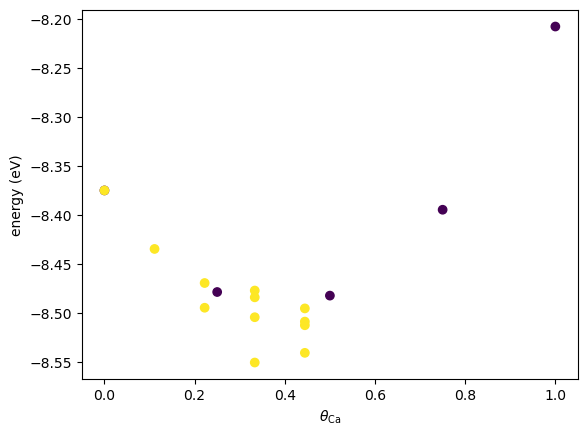

In [25]:
plt.scatter(df_pyiron['coverage'], df_pyiron['e_unit_cell'], c = df_pyiron['n_area']);
plt.xlabel(r'$\theta_{\mathrm{Ca}}$')
plt.ylabel('energy (eV)')

# convex hull plot

Text(0, 0.5, 'energy (eV)')

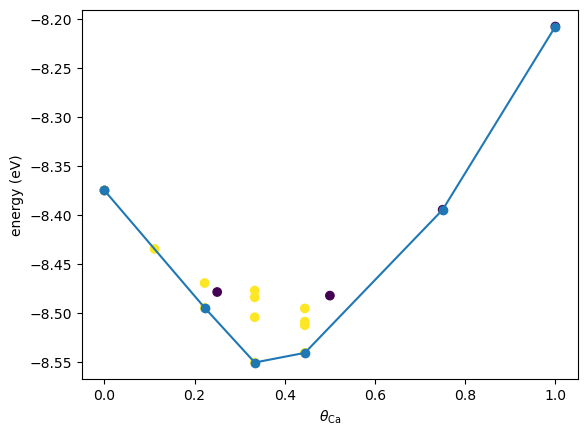

In [26]:
plt.scatter(df_pyiron['coverage'], df_pyiron['e_unit_cell'], c = df_pyiron['n_area'])

points = np.array([df_pyiron['coverage'], df_pyiron['e_unit_cell']]).T
hull = ConvexHull(points)
hull_indices = hull.vertices
args = np.argsort(df_pyiron['coverage'][hull_indices])
hull_indices = hull_indices[args]        

x_hull = df_pyiron['coverage'].values[hull_indices]
y_hull = df_pyiron['e_unit_cell'].values[hull_indices]
plt.plot(x_hull, y_hull, f'o-')    
plt.xlabel(r'$\theta_{\mathrm{Ca}}$')
plt.ylabel('energy (eV)')

# calculate chemical potential reference

The chemical potential references are the energies of bulk Mg and bulk Ca.

In [27]:
job = pr.create.job.Lammps("Mg_bulk")
job.potential = potential
job.structure = pr.create.structure.bulk('Mg')
job.calc_minimize(n_print = 1)
job.run()

The job Mg_bulk was saved and received the ID: 20


In [28]:
job = pr.create.job.Lammps("Ca_bulk")
job.potential = potential
job.structure = pr.create.structure.bulk('Ca')
job.calc_minimize(n_print = 1)
job.run()

The job Ca_bulk was saved and received the ID: 21


In [29]:
job = pr.load("Mg_bulk")
E_bulk_Mg = job.content['output/generic/energy_tot'][-1]/2
job = pr.load("Ca_bulk")
E_bulk_Ca = job.content['output/generic/energy_tot'][-1]

# plot the surface phase diagram

The surface phase diagram shows how the surface energies change with $\mu_{\rm Ca}$. 

$E^{\rm surf}_{\sigma}(\{\mu_{i}\})  = [E_{\sigma}^{\rm DFT} - \sum_{i = \rm Mg, Ca}n_{i,\sigma}  (E_{i-\rm bulk}^{\rm DFT} + \mu_{i})] - E^{\rm surf}_{\rm perfect} $

Since our $E_{\sigma}^{\rm DFT}$ is already normalized to surface unit cell, and we take $\mu_{\rm Mg} = 0$, the equation can be reduced to
$E^{\rm surf}_{\sigma}(\{\mu_{i}\})  = [E_{\sigma}^{\rm DFT} - \theta  (E_{\rm Ca-bulk}^{\rm DFT} + \mu_{\rm Ca}) - (N-\theta)E_{\rm Mg-bulk}^{\rm DFT} ]- E^{\rm surf}_{\rm perfect} $. Here $N$ is the number of atoms in one surface unit cell (in other words, the number of layers of the slab). We have set this to 6 when setting up the cell.


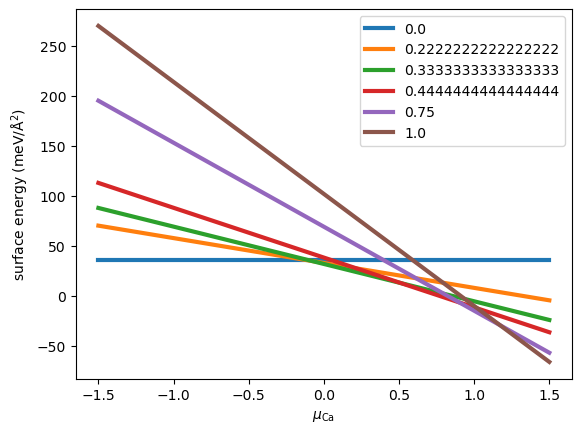

In [30]:
mu_sol = np.linspace(-1.5, 1.5, 1000)
G_mu = np.array(y_hull - x_hull*E_bulk_Ca - (6-x_hull)*E_bulk_Mg) - np.outer(x_hull, mu_sol).T
surface_area_unit_cell = df_pyiron['surface_area'][0]/4
G_mu_per_area = (G_mu - G_mu[0,0]/2)*1000/surface_area_unit_cell # convert the unit to meV/AA^2

for i, G in enumerate(G_mu_per_area.T):
    plt.plot(mu_sol, G, linewidth=3, label = str(x_hull[i]))
plt.legend()

plt.xlabel('$\mu_{\mathrm{Ca}}$')
plt.ylabel(r'surface energy (meV/$\mathrm{\AA}^2$)');

## better visualization

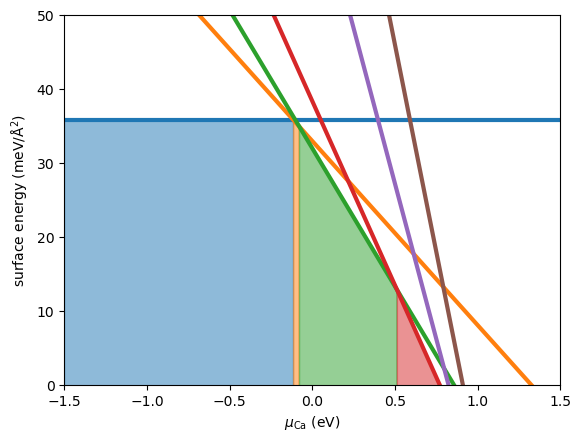

In [31]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
for i, G in enumerate(G_mu_per_area.T):
    plt.plot(mu_sol, G, linewidth=3, label = str(x_hull[i]))

lowest_phase = np.argmin(G_mu_per_area, axis = 1)
for i in set(lowest_phase):
    plt.fill_between(mu_sol, -60, G_mu_per_area.T[i], where = lowest_phase ==i, 
                    color = colors[i], alpha = 0.5)

plt.ylim(0, 50)
plt.xlim(-1.5, 1.5)
plt.xlabel('$\mu_{\mathrm{Ca}}$ (eV)')
plt.ylabel(r'surface energy (meV/$\mathrm{\AA}^2$)');
